In [68]:
# ============================================================
# 1. IMPORT LIBRARY
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib
import xgboost as xgb

In [69]:
# ============================================================
# 2. LOAD DATASET
# ============================================================

df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
display(df.head())
print(df.info())

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [70]:
# ============================================================
# 3. CLEANSING DATA
# ============================================================

# Hapus duplikat
df = df.drop_duplicates()

# Cek missing values
print(df.isnull().sum())

# Jika ada missing — misalnya isi nilai default
# df = df.fillna(method="ffill")  # optional

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [71]:
# Setelah df = df.drop_duplicates()
df.to_csv("hasil_cleansing.csv", index=False)

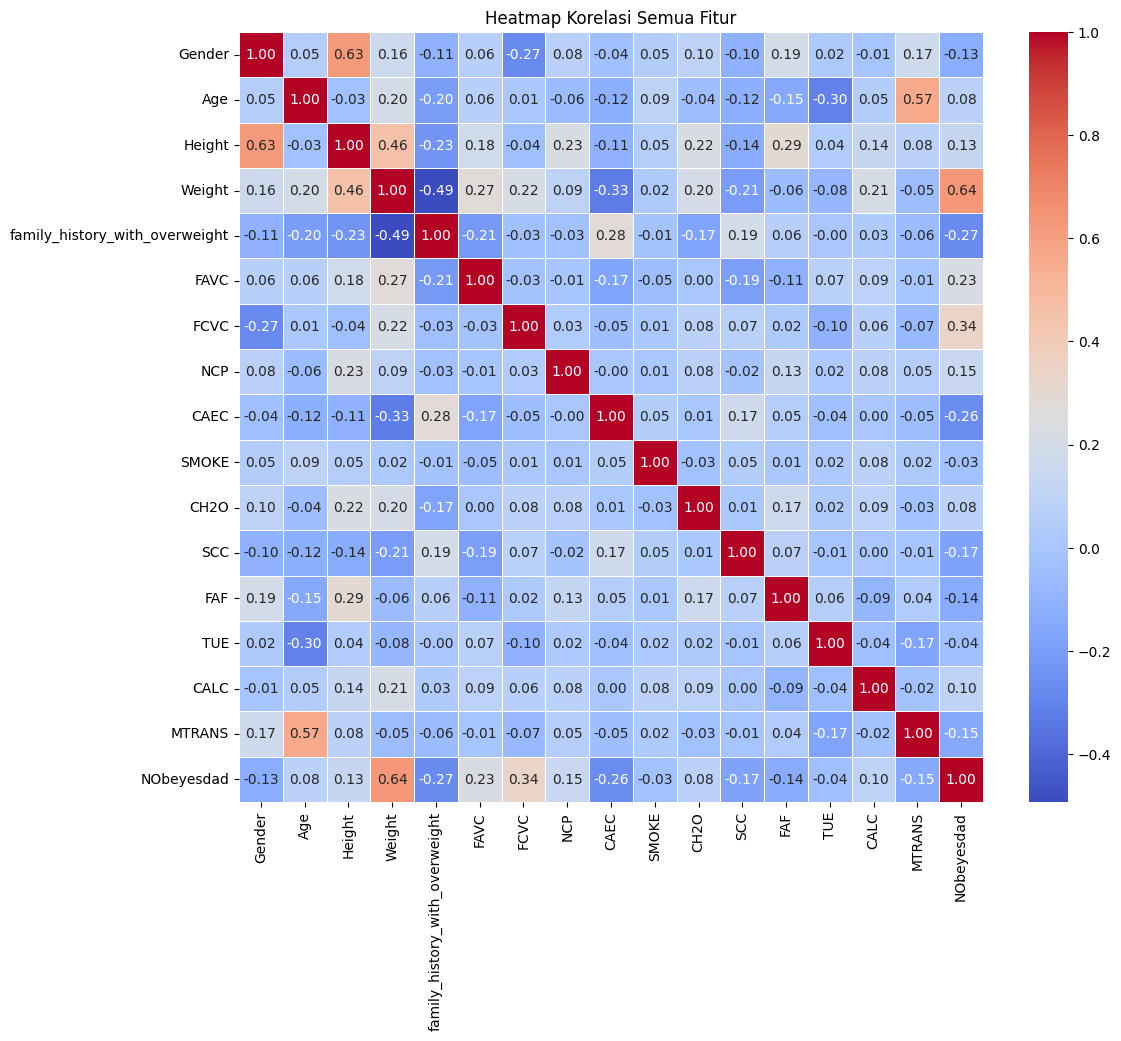

Tabel Korelasi Fitur terhadap NObeyesdad (diurutkan):


,Fitur,Korelasi
0,Weight,0.636115
1,FCVC,0.339929
2,family_history_with_overweight,0.267888
3,CAEC,0.262454
4,FAVC,0.226236
5,SCC,0.172887
6,MTRANS,0.148298
7,NCP,0.146897
8,FAF,0.142296
9,Height,0.133336


In [72]:
# ============================================================
# 4a. KORELASI SEMUA FITUR TERHADAP TARGET (NObeyesdad)
# ============================================================
# Encode semua fitur kategorikal ke numerik untuk korelasi
all_corr_df = df.copy()
for col in all_corr_df.select_dtypes(include=['object']).columns:
    all_corr_df[col] = pd.factorize(all_corr_df[col])[0]

# Hitung matriks korelasi
all_corr_matrix = all_corr_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(all_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi Semua Fitur')
plt.show()

# Tampilkan korelasi fitur terhadap target (NObeyesdad)
fitur_target = 'NObeyesdad'
fitur_corr = all_corr_matrix[fitur_target].drop(fitur_target).abs().sort_values(ascending=False)
fitur_corr_table = pd.DataFrame({'Fitur': fitur_corr.index, 'Korelasi': fitur_corr.values})
print(f'Tabel Korelasi Fitur terhadap {fitur_target} (diurutkan):')
display(fitur_corr_table)

In [73]:
# ============================================================
# 4. PILIH 8 FITUR UTAMA (HASIL KORELASI)
# ============================================================

selected_features = [
    "Weight",
    "Height",
    "FCVC",
    "FAVC",
    "family_history_with_overweight",
    "NCP",
    "Age",
    "MTRANS"
# MTRANS adalah fitur kategorikal, pastikan di-preprocessing
]

target = "NObeyesdad"

X = df[selected_features]
y = df[target]

print("Fitur yang digunakan (hasil korelasi)")
display(X.head())
print(" ")
print("Nilai Target")
display(y.head())

Fitur yang digunakan (hasil korelasi)


,Weight,Height,FCVC,FAVC,family_history_with_overweight,NCP,Age,MTRANS
0,64.0,1.62,2.0,no,yes,3.0,21.0,Public_Transportation
1,56.0,1.52,3.0,no,yes,3.0,21.0,Public_Transportation
2,77.0,1.80,2.0,no,yes,3.0,23.0,Public_Transportation
3,87.0,1.80,3.0,no,no,3.0,27.0,Walking
4,89.8,1.78,2.0,no,no,1.0,22.0,Public_Transportation


 
Nilai Target


0          Normal_Weight
1          Normal_Weight
2          Normal_Weight
3     Overweight_Level_I
4    Overweight_Level_II
Name: NObeyesdad, dtype: object

In [74]:
# ============================================================
# 5. ENCODING TARGET (LABEL)
# ============================================================
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label kelas:", label_encoder.classes_)

Label kelas: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']
 ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


In [75]:
# ============================================================
# 6. IDENTIFIKASI FITUR NUMERIK & KATEGORIKAL (FITUR BARU)
# ============================================================

numeric_features = ["Weight", "Height", "FCVC", "NCP", "Age"]
categorical_features = ["FAVC", "family_history_with_overweight", "MTRANS"]

numeric_features, categorical_features

(['Weight', 'Height', 'FCVC', 'NCP', 'Age'],
 ['FAVC', 'family_history_with_overweight', 'MTRANS'])

In [141]:
# ============================================================
# 7. PIPELINE PREPROCESSING (FITUR BARU)
# - OneHotEncoder untuk kategori
# - StandardScaler untuk numerik
# ============================================================

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

In [146]:
# ============================================================
# 8. SPLIT DATA
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train.shape, X_test.shape

print("Jumlah data latih:", len(X_train))
print("Jumlah data uji:", len(X_test))

Jumlah data latih: 1669
Jumlah data uji: 418


In [147]:
# ============================================================
# 9. BENTUK PIPELINE DENGAN XGBOOST
# ============================================================

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss'
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', xgb_clf)
])


In [148]:
# ============================================================
# 10. TRAIN MODEL
# ============================================================

model.fit(X_train, y_train)
print("Training selesai!")


Training selesai!


Akurasi: 0.9808612440191388

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00        53
      Normal_Weight       0.98      0.96      0.97        57
     Obesity_Type_I       0.99      0.99      0.99        70
    Obesity_Type_II       1.00      1.00      1.00        60
   Obesity_Type_III       1.00      1.00      1.00        65
 Overweight_Level_I       0.96      0.93      0.94        55
Overweight_Level_II       0.93      0.98      0.96        58

           accuracy                           0.98       418
          macro avg       0.98      0.98      0.98       418
       weighted avg       0.98      0.98      0.98       418



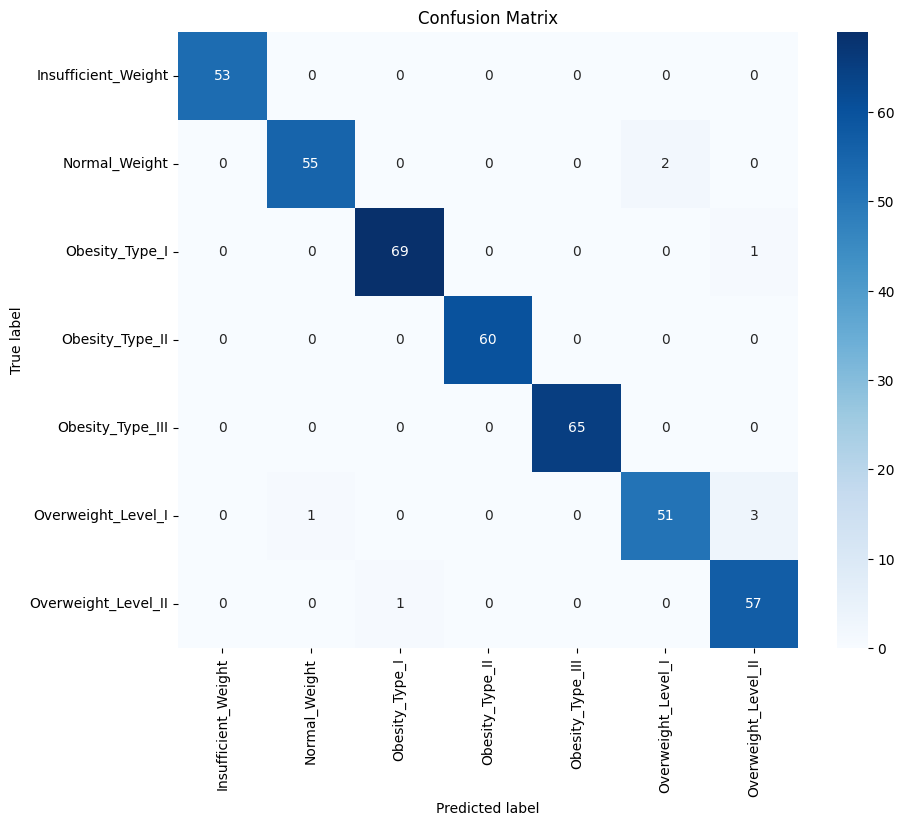

In [149]:
# ============================================================
# 11. EVALUASI MODEL
# ============================================================

y_pred = model.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get class labels from the label_encoder
class_labels = label_encoder.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [90]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("classification_report.csv")

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
cm_df.to_csv("confusion_matrix.csv")

In [91]:
# ============================================================
# 11b. PERBANDINGAN MODEL: XGBoost, SVM, Random Forest
# ============================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

models = {
    'XGBoost': model,  # pipeline sudah ada
    'Random Forest': make_pipeline(preprocessor, RandomForestClassifier(n_estimators=200, random_state=42)),
    'SVM': make_pipeline(preprocessor, SVC(kernel='rbf', probability=True, random_state=42))
}

results = []
for name, mdl in models.items():
    if name != 'XGBoost':
        mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({'Model': name, 'Akurasi': acc})
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Tampilkan tabel perbandingan akurasi
import pandas as pd
results_df = pd.DataFrame(results)
print("\nTabel Perbandingan Akurasi Model:")
display(results_df)


XGBoost Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      1.00      1.00        53
      Normal_Weight       0.98      0.96      0.97        57
     Obesity_Type_I       0.99      0.99      0.99        70
    Obesity_Type_II       1.00      1.00      1.00        60
   Obesity_Type_III       1.00      1.00      1.00        65
 Overweight_Level_I       0.96      0.93      0.94        55
Overweight_Level_II       0.93      0.98      0.96        58

           accuracy                           0.98       418
          macro avg       0.98      0.98      0.98       418
       weighted avg       0.98      0.98      0.98       418


Random Forest Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.98      0.98      0.98        53
      Normal_Weight       0.84      0.91      0.87        57
     Obesity_Type_I       1.00      0.99      0.99        70
    Obesity

,Model,Akurasi
0,XGBoost,0.980861
1,Random Forest,0.956938
2,SVM,0.901914


In [83]:
# ============================================================
# 12. SIMPAN MODEL, ENCODER, SCALER
# ============================================================

joblib.dump(model, "xgb_obesity_model.joblib")
joblib.dump(label_encoder, "label_encoder.joblib")

print("Model dan encoder disimpan.")

Model dan encoder disimpan.


In [84]:
# ============================================================
# 13. EKSPORT DATASET HASIL NORMALISASI (FITUR BARU)
# ============================================================

# Fit preprocessor pada seluruh data
preprocessor.fit(X)
X_normalized = preprocessor.transform(X)

# Ambil nama kolom hasil transformasi
num_cols = numeric_features
cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_cols = list(num_cols) + list(cat_cols)

# Buat dataframe hasil transformasi dengan nama kolom yang benar
df_norm = pd.DataFrame(
    X_normalized.toarray() if hasattr(X_normalized, "toarray") else X_normalized,
    columns=all_cols
)

df_norm.to_csv("obesity_normalized.csv", index=False)
print("File normalisasi disimpan!")

File normalisasi disimpan!


C:\Users\User\AppData\Local\Temp\ipykernel_12164\1004058485.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues')
C:\Users\User\AppData\Local\Temp\ipykernel_12164\1004058485.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


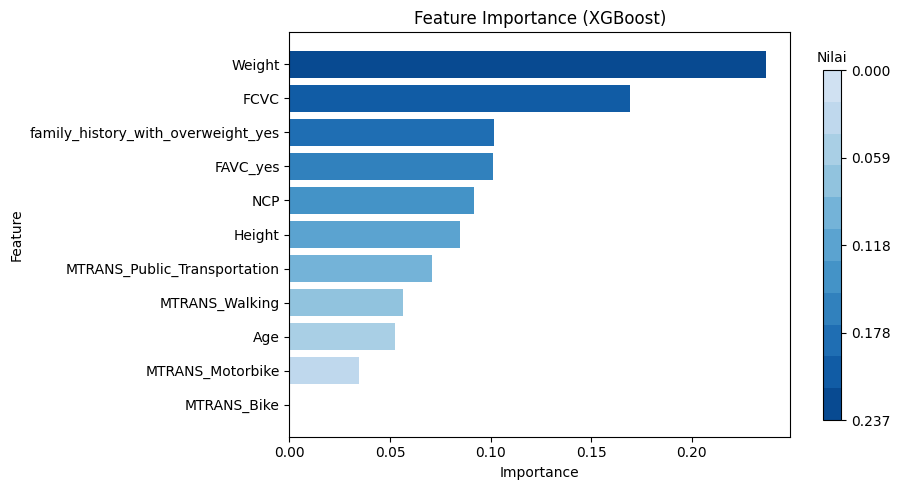

In [85]:
# ============================================================
# FEATURE IMPORTANCE XGBOOST (FITUR BARU)
# ============================================================

importances = model.named_steps['classifier'].feature_importances_
feature_names = (
    numeric_features +
    list(model.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(categorical_features))
    if hasattr(model.named_steps['preprocess'].named_transformers_['cat'], 'get_feature_names_out') else []
)

# Urutkan berdasarkan importance (dari terbesar ke terkecil)
sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
sorted_features = np.array(feature_names)[sorted_idx]

# Warna gradasi biru: biru gelap untuk nilai terbesar, makin cerah untuk nilai kecil
from matplotlib import cm
cmap = cm.get_cmap('Blues')
colors = [cmap(0.9 - 0.7 * (i / (len(sorted_features)-1))) for i in range(len(sorted_features))]

plt.figure(figsize=(9, 5))
bars = plt.barh(sorted_features, sorted_importances, color=colors)
plt.gca().invert_yaxis()  # Fitur terpenting di atas
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Legend gradasi bar tegak di samping kanan, hanya bar warna dan nilai
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase
import numpy as np

cmap_legend = ListedColormap(colors)
cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=sorted_importances.min(), vmax=sorted_importances.max())
cb = ColorbarBase(cbar_ax, cmap=cmap_legend, orientation='vertical', ticks=[0, 1])
tick_locs = np.linspace(0, 1, 5)
tick_labels = np.linspace(sorted_importances.max(), sorted_importances.min(), 5)
cbar_ax.set_yticks(tick_locs)
cbar_ax.set_yticklabels([f"{v:.3f}" for v in tick_labels])
cbar_ax.set_title('Nilai', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()